### Importing Libraries

In [23]:
pip install pytorch-fid

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
from torchvision import datasets, transforms
from tqdm import trange
import argparse
from tqdm import tqdm
import time
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torchvision.utils import save_image
from pytorch_fid import fid_score


### Defining Model

In [25]:
class Generator(nn.Module):
    def __init__(self, g_output_dim, latent_dim=200, num_classes=10):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        self.num_classes = num_classes

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim, K=11):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, K)
        self.K = K

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return self.fc4(x)





### Loss Fn

In [26]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d = 100 #dimension of latent space
K = 11 #size of the output of discrimnator

def D_train(x, y, G, D, D_optimizer,mu,sigma, criterion):
    #=======================Train the discriminator=======================#
    G.train()
    D.train()

    D.zero_grad()


    # train discriminator on real samples
    x_real, y_real = x, y
    x_real, y_real = x_real.to(DEVICE), y_real.to(DEVICE)

    D_output_real = D(x_real)
    D_real_loss = criterion(D_output_real, y_real)

    #representing one of the K Gaussian distributions
    k_values = torch.randint(0, 10, (x.shape[0],))
    y = torch.eye(K)[k_values].to(DEVICE)
    y_indices = k_values.to(DEVICE)
    N = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))

    #random noise
    z = N.sample((x.shape[0],)).to(DEVICE).to(torch.float32)

    #the vector of latent space sampled from the Gaussian Mixture
    z_tilde = mu[y_indices] + (sigma[y_indices] * z)

    #Generate fake sample x_fake
    x_fake = G(z_tilde)

    D_output_fake =  D(x_fake)
    target_fake = torch.full((x.shape[0],), 10, dtype=torch.long).to(DEVICE)

    D_fake_loss = criterion(D_output_fake, target_fake)

    # gradient backpropagation and optimization of D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()


def G_train(x, y, G, D, G_optimizer,mu,sigma ,criterion):
    #=======================Train the generator=======================#
    G.train()
    D.train()

    G.zero_grad()



    #representing one of the K Gaussian distributions
    k_values = torch.randint(0, 10, (x.shape[0],))
    y = torch.eye(K)[k_values].to(DEVICE)
    y_indices = k_values.to(DEVICE)
    N = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    #random noise
    z = N.sample((x.shape[0],)).to(DEVICE).to(torch.float32)

    #the vector of latent space sampled from the Gaussian Mixture
    z_tilde = z_tilde = mu[y_indices] + (sigma[y_indices] * z)

    G_output = G(z_tilde)

    D_output = D(G_output)
    G_loss = criterion(D_output, torch.argmax(y, dim=1)) #le vrai y

    # gradient backpropagation and optimization of G and GM's parameters
    G_loss.backward()
    G_optimizer.step()


    return G_loss.data.item()


In [27]:
def save_models(G, D, filepath,folder):

    if isinstance(G, torch.nn.DataParallel):
        torch.save(G.module.state_dict(), os.path.join(folder, f'{filepath}_G.pth'))
    else:
        torch.save(G.state_dict(), os.path.join(folder, f'{filepath}_G.pth'))

    if isinstance(D, torch.nn.DataParallel):
        torch.save(D.module.state_dict(), os.path.join(folder, f'{filepath}_D.pth'))
    else:
        torch.save(D.state_dict(), os.path.join(folder, f'{filepath}_D.pth'))

    print(f"Models saved to {folder}")



def load_model(model, folder,epoch):
    model.load_state_dict(torch.load(os.path.join(folder, f'epoch_{epoch}_G.pth')))
    return model


### Load training data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(root='data/MNIST/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


### Initializing Instances

In [28]:
mnist_dim = 784
K = 11
d = 200
sigma=1
G = Generator(g_output_dim=mnist_dim).to(DEVICE)
D = Discriminator(d_input_dim=mnist_dim).to(DEVICE)
mu = (2  * torch.rand(K, d) - 1).to(DEVICE)
sigma1 = sigma*(torch.ones(K, d)).to(DEVICE)




epochs = 100
log_interval = 10

print('Model loaded.')

# define loss
criterion = nn.CrossEntropyLoss()

# define optimizers
G_optimizer = optim.Adam(G.parameters(), lr = 0.0005)
D_optimizer = optim.Adam(D.parameters(), lr = 0.0005)



Model loaded.


### Training

In [ ]:
folder="checkpoints"
if not os.path.exists(folder):
        os.makedirs(folder)

In [ ]:
G_l1 = []
D_l1 = []
G_grad_norms = []
D_grad_norms = []

# Loop over the number of epochs
for epoch in range(1, epochs + 1):
    G_loss_total = 0.0
    D_loss_total = 0.0
    D1=0.0
    G1=0.0

    # Loop over the training dataset
    for batch_idx, (x, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")):
        x = x.view(-1, 784).to(DEVICE)  # Flatten the images (for MNIST)
        y = y.to(DEVICE)

        # Train the Discriminator
        D_loss = D_train(x, y, G, D, D_optimizer, mu, sigma1, criterion)
        D_loss_total += D_loss
        # Capture gradients for Discriminator
        D_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in D.parameters() if param.grad is not None]))
        D1+=D_grad_norm


        # Train the Generator
        G_loss = G_train(x, y, G, D, G_optimizer, mu, sigma1, criterion)
        G_loss_total += G_loss
        # Capture gradients for Generator
        G_grad_norm = torch.norm(torch.cat([param.grad.view(-1) for param in G.parameters() if param.grad is not None]))
        G1+=G_grad_norm


    # Average losses for the epoch
    D_loss_avg = D_loss_total / len(train_loader)
    G_loss_avg = G_loss_total / len(train_loader)
    G_grad_avg = G1/len(train_loader)
    D_grad_avg = D1/len(train_loader)
    D_l1.append(D_loss_avg)
    G_l1.append(G_loss_avg)
    G_grad_norms.append(G_grad_avg)
    D_grad_norms.append(D_grad_avg)


    # Logging the progress
    print(f"Epoch [{epoch}/{epochs}], D Loss: {D_loss_avg:.4f}, G Loss: {G_loss_avg:.4f}")

    # Save the model at specified intervals
    if epoch % log_interval == 0:
        save_models(G, D, f'epoch_{epoch}','checkpoints')
        print(f"Models saved at epoch {epoch}")

print("Training complete.")


Epoch 1/100: 100%|██████████| 938/938 [00:25<00:00, 37.24it/s]


Epoch [1/100], D Loss: 0.0296, G Loss: 29.1715


Epoch 2/100: 100%|██████████| 938/938 [00:24<00:00, 37.67it/s]


Epoch [2/100], D Loss: 0.0246, G Loss: 28.7290


Epoch 3/100: 100%|██████████| 938/938 [00:24<00:00, 37.89it/s]


Epoch [3/100], D Loss: 0.0301, G Loss: 58.3389


Epoch 4/100: 100%|██████████| 938/938 [00:24<00:00, 37.92it/s]


Epoch [4/100], D Loss: 0.0206, G Loss: 49.3084


Epoch 5/100: 100%|██████████| 938/938 [00:25<00:00, 37.44it/s]


Epoch [5/100], D Loss: 0.0243, G Loss: 33.6819


Epoch 6/100: 100%|██████████| 938/938 [00:24<00:00, 37.92it/s]


Epoch [6/100], D Loss: 0.0256, G Loss: 34.2187


Epoch 7/100: 100%|██████████| 938/938 [00:24<00:00, 37.90it/s]


Epoch [7/100], D Loss: 0.0241, G Loss: 38.4999


Epoch 8/100: 100%|██████████| 938/938 [00:24<00:00, 38.07it/s]


Epoch [8/100], D Loss: 0.0353, G Loss: 66.8317


Epoch 9/100: 100%|██████████| 938/938 [00:24<00:00, 37.63it/s]


Epoch [9/100], D Loss: 0.0147, G Loss: 20.9999


Epoch 10/100: 100%|██████████| 938/938 [00:25<00:00, 37.11it/s]


Epoch [10/100], D Loss: 0.0259, G Loss: 26.1100
Models saved to checkpoints
Models saved at epoch 10


Epoch 11/100: 100%|██████████| 938/938 [00:25<00:00, 37.26it/s]


Epoch [11/100], D Loss: 0.0162, G Loss: 30.6797


Epoch 12/100: 100%|██████████| 938/938 [00:25<00:00, 37.50it/s]


Epoch [12/100], D Loss: 0.0212, G Loss: 34.5378


Epoch 13/100: 100%|██████████| 938/938 [00:24<00:00, 37.62it/s]


Epoch [13/100], D Loss: 0.0212, G Loss: 27.3529


Epoch 14/100: 100%|██████████| 938/938 [00:24<00:00, 37.68it/s]


Epoch [14/100], D Loss: 0.0193, G Loss: 33.9580


Epoch 15/100: 100%|██████████| 938/938 [00:24<00:00, 37.64it/s]


Epoch [15/100], D Loss: 0.0222, G Loss: 29.0964


Epoch 16/100: 100%|██████████| 938/938 [00:24<00:00, 37.84it/s]


Epoch [16/100], D Loss: 0.0166, G Loss: 39.7037


Epoch 17/100: 100%|██████████| 938/938 [00:25<00:00, 37.21it/s]


Epoch [17/100], D Loss: 0.0228, G Loss: 35.0128


Epoch 18/100: 100%|██████████| 938/938 [00:24<00:00, 37.91it/s]


Epoch [18/100], D Loss: 0.0210, G Loss: 36.6523


Epoch 19/100: 100%|██████████| 938/938 [00:24<00:00, 37.70it/s]


Epoch [19/100], D Loss: 0.0213, G Loss: 31.2126


Epoch 20/100: 100%|██████████| 938/938 [00:24<00:00, 37.69it/s]


Epoch [20/100], D Loss: 0.0280, G Loss: 63.7607
Models saved to checkpoints
Models saved at epoch 20


Epoch 21/100: 100%|██████████| 938/938 [00:24<00:00, 37.54it/s]


Epoch [21/100], D Loss: 0.0175, G Loss: 48.2216


Epoch 22/100: 100%|██████████| 938/938 [00:24<00:00, 37.72it/s]


Epoch [22/100], D Loss: 0.0206, G Loss: 31.9677


Epoch 23/100: 100%|██████████| 938/938 [00:24<00:00, 37.83it/s]


Epoch [23/100], D Loss: 0.0168, G Loss: 30.9440


Epoch 24/100: 100%|██████████| 938/938 [00:25<00:00, 37.42it/s]


Epoch [24/100], D Loss: 0.0226, G Loss: 80.7135


Epoch 25/100: 100%|██████████| 938/938 [00:25<00:00, 37.49it/s]


Epoch [25/100], D Loss: 0.0202, G Loss: 100.6434


Epoch 26/100: 100%|██████████| 938/938 [00:24<00:00, 37.98it/s]


Epoch [26/100], D Loss: 0.0228, G Loss: 69.3087


Epoch 27/100: 100%|██████████| 938/938 [00:25<00:00, 37.44it/s]


Epoch [27/100], D Loss: 0.0167, G Loss: 53.5815


Epoch 28/100: 100%|██████████| 938/938 [00:24<00:00, 37.59it/s]


Epoch [28/100], D Loss: 0.0180, G Loss: 48.4807


Epoch 29/100: 100%|██████████| 938/938 [00:24<00:00, 37.59it/s]


Epoch [29/100], D Loss: 0.0186, G Loss: 49.4165


Epoch 30/100: 100%|██████████| 938/938 [00:25<00:00, 37.11it/s]


Epoch [30/100], D Loss: 0.0181, G Loss: 41.4850
Models saved to checkpoints
Models saved at epoch 30


Epoch 31/100: 100%|██████████| 938/938 [00:24<00:00, 37.83it/s]


Epoch [31/100], D Loss: 0.0195, G Loss: 43.4272


Epoch 32/100: 100%|██████████| 938/938 [00:25<00:00, 37.35it/s]


Epoch [32/100], D Loss: 0.0206, G Loss: 41.2577


Epoch 33/100: 100%|██████████| 938/938 [00:24<00:00, 37.77it/s]


Epoch [33/100], D Loss: 0.0209, G Loss: 47.8078


Epoch 34/100: 100%|██████████| 938/938 [00:24<00:00, 37.53it/s]


Epoch [34/100], D Loss: 0.0164, G Loss: 43.5332


Epoch 35/100: 100%|██████████| 938/938 [00:24<00:00, 37.61it/s]


Epoch [35/100], D Loss: 0.0218, G Loss: 35.4892


Epoch 36/100: 100%|██████████| 938/938 [00:24<00:00, 37.77it/s]


Epoch [36/100], D Loss: 0.0169, G Loss: 36.9493


Epoch 37/100: 100%|██████████| 938/938 [00:25<00:00, 37.46it/s]


Epoch [37/100], D Loss: 0.0834, G Loss: 42.6640


Epoch 38/100: 100%|██████████| 938/938 [00:24<00:00, 37.70it/s]


Epoch [38/100], D Loss: 0.0240, G Loss: 140.0108


Epoch 39/100: 100%|██████████| 938/938 [00:24<00:00, 37.71it/s]


Epoch [39/100], D Loss: 0.0047, G Loss: 123.3545


Epoch 40/100: 100%|██████████| 938/938 [00:25<00:00, 37.45it/s]


Epoch [40/100], D Loss: 0.0145, G Loss: 142.6955
Models saved to checkpoints
Models saved at epoch 40


Epoch 41/100: 100%|██████████| 938/938 [00:25<00:00, 37.31it/s]


Epoch [41/100], D Loss: 0.0156, G Loss: 101.7108


Epoch 42/100: 100%|██████████| 938/938 [00:25<00:00, 37.06it/s]


Epoch [42/100], D Loss: 0.0187, G Loss: 95.9937


Epoch 43/100: 100%|██████████| 938/938 [00:25<00:00, 37.32it/s]


Epoch [43/100], D Loss: 0.0155, G Loss: 74.7774


Epoch 44/100: 100%|██████████| 938/938 [00:25<00:00, 36.78it/s]


Epoch [44/100], D Loss: 0.0202, G Loss: 64.1047


Epoch 45/100: 100%|██████████| 938/938 [00:25<00:00, 36.90it/s]


Epoch [45/100], D Loss: 0.0113, G Loss: 76.1648


Epoch 46/100: 100%|██████████| 938/938 [00:25<00:00, 37.01it/s]


Epoch [46/100], D Loss: 0.0229, G Loss: 57.7508


Epoch 47/100: 100%|██████████| 938/938 [00:25<00:00, 37.37it/s]


Epoch [47/100], D Loss: 0.0246, G Loss: 54.1662


Epoch 48/100: 100%|██████████| 938/938 [00:25<00:00, 37.06it/s]


Epoch [48/100], D Loss: 0.0189, G Loss: 51.9678


Epoch 49/100: 100%|██████████| 938/938 [00:25<00:00, 37.23it/s]


Epoch [49/100], D Loss: 0.0178, G Loss: 55.2999


Epoch 50/100: 100%|██████████| 938/938 [00:25<00:00, 37.41it/s]


Epoch [50/100], D Loss: 0.0226, G Loss: 54.6830
Models saved to checkpoints
Models saved at epoch 50


Epoch 51/100: 100%|██████████| 938/938 [00:25<00:00, 37.09it/s]


Epoch [51/100], D Loss: 0.0283, G Loss: 64.8096


Epoch 52/100: 100%|██████████| 938/938 [00:25<00:00, 37.28it/s]


Epoch [52/100], D Loss: 0.0208, G Loss: 53.7835


Epoch 53/100: 100%|██████████| 938/938 [00:25<00:00, 37.43it/s]


Epoch [53/100], D Loss: 0.0152, G Loss: 47.1274


Epoch 54/100: 100%|██████████| 938/938 [00:25<00:00, 36.98it/s]


Epoch [54/100], D Loss: 0.0238, G Loss: 63.2057


Epoch 55/100: 100%|██████████| 938/938 [00:24<00:00, 37.76it/s]


Epoch [55/100], D Loss: 0.0164, G Loss: 52.5935


Epoch 56/100: 100%|██████████| 938/938 [00:24<00:00, 38.25it/s]


Epoch [56/100], D Loss: 0.0200, G Loss: 52.4729


Epoch 57/100: 100%|██████████| 938/938 [00:24<00:00, 38.16it/s]


Epoch [57/100], D Loss: 0.0175, G Loss: 49.3358


Epoch 58/100: 100%|██████████| 938/938 [00:24<00:00, 37.93it/s]


Epoch [58/100], D Loss: 0.0166, G Loss: 58.9946


Epoch 59/100: 100%|██████████| 938/938 [00:24<00:00, 37.91it/s]


Epoch [59/100], D Loss: 0.0235, G Loss: 37.6460


Epoch 60/100: 100%|██████████| 938/938 [00:24<00:00, 38.37it/s]


Epoch [60/100], D Loss: 0.0176, G Loss: 36.7217
Models saved to checkpoints
Models saved at epoch 60


Epoch 61/100: 100%|██████████| 938/938 [00:24<00:00, 38.03it/s]


Epoch [61/100], D Loss: 0.0218, G Loss: 33.0786


Epoch 62/100: 100%|██████████| 938/938 [00:24<00:00, 38.29it/s]


Epoch [62/100], D Loss: 0.0219, G Loss: 43.7113


Epoch 63/100: 100%|██████████| 938/938 [00:24<00:00, 37.64it/s]


Epoch [63/100], D Loss: 0.0197, G Loss: 53.7081


Epoch 64/100: 100%|██████████| 938/938 [00:24<00:00, 38.09it/s]


Epoch [64/100], D Loss: 0.0119, G Loss: 45.0528


Epoch 65/100: 100%|██████████| 938/938 [00:24<00:00, 38.18it/s]


Epoch [65/100], D Loss: 0.0239, G Loss: 44.9980


Epoch 66/100: 100%|██████████| 938/938 [00:24<00:00, 37.94it/s]


Epoch [66/100], D Loss: 0.0247, G Loss: 78.4610


Epoch 67/100: 100%|██████████| 938/938 [00:24<00:00, 37.86it/s]


Epoch [67/100], D Loss: 0.0121, G Loss: 114.1691


Epoch 68/100: 100%|██████████| 938/938 [00:24<00:00, 37.86it/s]


Epoch [68/100], D Loss: 0.0189, G Loss: 110.2084


Epoch 69/100: 100%|██████████| 938/938 [00:24<00:00, 37.77it/s]


Epoch [69/100], D Loss: 0.0187, G Loss: 65.7998


Epoch 70/100: 100%|██████████| 938/938 [00:24<00:00, 38.29it/s]


Epoch [70/100], D Loss: 0.0192, G Loss: 82.9792
Models saved to checkpoints
Models saved at epoch 70


Epoch 71/100: 100%|██████████| 938/938 [00:24<00:00, 38.03it/s]


Epoch [71/100], D Loss: 0.0160, G Loss: 50.5560


Epoch 72/100: 100%|██████████| 938/938 [00:24<00:00, 38.50it/s]


Epoch [72/100], D Loss: 0.0227, G Loss: 45.3627


Epoch 73/100: 100%|██████████| 938/938 [00:24<00:00, 38.17it/s]


Epoch [73/100], D Loss: 0.0206, G Loss: 49.2540


Epoch 74/100: 100%|██████████| 938/938 [00:24<00:00, 38.18it/s]


Epoch [74/100], D Loss: 0.0226, G Loss: 86.5603


Epoch 75/100: 100%|██████████| 938/938 [00:24<00:00, 37.88it/s]


Epoch [75/100], D Loss: 0.0178, G Loss: 63.6726


Epoch 76/100: 100%|██████████| 938/938 [00:24<00:00, 37.86it/s]


Epoch [76/100], D Loss: 0.0197, G Loss: 63.5324


Epoch 77/100: 100%|██████████| 938/938 [00:24<00:00, 38.09it/s]


Epoch [77/100], D Loss: 0.0219, G Loss: 59.5614


Epoch 78/100: 100%|██████████| 938/938 [00:24<00:00, 38.17it/s]


Epoch [78/100], D Loss: 0.0180, G Loss: 61.2948


Epoch 79/100: 100%|██████████| 938/938 [00:24<00:00, 38.21it/s]


Epoch [79/100], D Loss: 0.0287, G Loss: 97.0047


Epoch 80/100: 100%|██████████| 938/938 [00:24<00:00, 38.10it/s]


Epoch [80/100], D Loss: 0.0127, G Loss: 74.5355
Models saved to checkpoints
Models saved at epoch 80


Epoch 81/100: 100%|██████████| 938/938 [00:24<00:00, 38.42it/s]


Epoch [81/100], D Loss: 0.0271, G Loss: 67.7650


Epoch 82/100: 100%|██████████| 938/938 [00:24<00:00, 38.52it/s]


Epoch [82/100], D Loss: 0.0117, G Loss: 66.6649


Epoch 83/100: 100%|██████████| 938/938 [00:24<00:00, 37.91it/s]


Epoch [83/100], D Loss: 0.0192, G Loss: 58.3876


Epoch 84/100: 100%|██████████| 938/938 [00:24<00:00, 38.09it/s]


Epoch [84/100], D Loss: 0.0222, G Loss: 66.1652


Epoch 85/100: 100%|██████████| 938/938 [00:24<00:00, 37.91it/s]


Epoch [85/100], D Loss: 0.0174, G Loss: 62.4637


Epoch 86/100: 100%|██████████| 938/938 [00:24<00:00, 37.89it/s]


Epoch [86/100], D Loss: 0.0203, G Loss: 57.5587


Epoch 87/100: 100%|██████████| 938/938 [00:24<00:00, 37.90it/s]


Epoch [87/100], D Loss: 0.0219, G Loss: 58.8230


Epoch 88/100: 100%|██████████| 938/938 [00:24<00:00, 37.81it/s]


Epoch [88/100], D Loss: 0.0187, G Loss: 56.4207


Epoch 89/100: 100%|██████████| 938/938 [00:24<00:00, 38.03it/s]


Epoch [89/100], D Loss: 0.0208, G Loss: 72.8896


Epoch 90/100: 100%|██████████| 938/938 [00:24<00:00, 38.07it/s]


Epoch [90/100], D Loss: 0.0193, G Loss: 81.1390
Models saved to checkpoints
Models saved at epoch 90


Epoch 91/100: 100%|██████████| 938/938 [00:24<00:00, 37.87it/s]


Epoch [91/100], D Loss: 0.0198, G Loss: 78.9416


Epoch 92/100: 100%|██████████| 938/938 [00:24<00:00, 38.04it/s]


Epoch [92/100], D Loss: 0.0143, G Loss: 85.3462


Epoch 93/100: 100%|██████████| 938/938 [00:24<00:00, 38.10it/s]


Epoch [93/100], D Loss: 0.0239, G Loss: 78.1230


Epoch 94/100: 100%|██████████| 938/938 [00:24<00:00, 38.02it/s]


Epoch [94/100], D Loss: 0.0182, G Loss: 77.6425


Epoch 95/100: 100%|██████████| 938/938 [00:24<00:00, 38.55it/s]


Epoch [95/100], D Loss: 0.0210, G Loss: 78.0747


Epoch 96/100: 100%|██████████| 938/938 [00:24<00:00, 37.78it/s]


Epoch [96/100], D Loss: 0.0246, G Loss: 78.5509


Epoch 97/100: 100%|██████████| 938/938 [00:24<00:00, 38.54it/s]


Epoch [97/100], D Loss: 0.0156, G Loss: 91.3985


Epoch 98/100: 100%|██████████| 938/938 [00:25<00:00, 37.20it/s]


Epoch [98/100], D Loss: 0.0232, G Loss: 94.2990


Epoch 99/100: 100%|██████████| 938/938 [00:25<00:00, 37.08it/s]


Epoch [99/100], D Loss: 0.0228, G Loss: 97.8027


Epoch 100/100: 100%|██████████| 938/938 [00:25<00:00, 36.63it/s]

Epoch [100/100], D Loss: 0.0166, G Loss: 122.4188
Models saved to checkpoints
Models saved at epoch 100
Training complete.


In [ ]:
from google.colab import files
!zip -r checkpoints.zip checkpoints/
files.download('checkpoints.zip')

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/epoch_100_G.pth (deflated 7%)
  adding: checkpoints/epoch_50_D.pth (deflated 7%)
  adding: checkpoints/epoch_30_D.pth (deflated 7%)
  adding: checkpoints/epoch_50_G.pth (deflated 7%)
  adding: checkpoints/epoch_40_G.pth (deflated 7%)
  adding: checkpoints/epoch_80_D.pth (deflated 7%)
  adding: checkpoints/epoch_30_G.pth (deflated 7%)
  adding: checkpoints/epoch_10_G.pth (deflated 7%)
  adding: checkpoints/epoch_70_G.pth (deflated 7%)
  adding: checkpoints/epoch_100_D.pth (deflated 7%)
  adding: checkpoints/epoch_20_G.pth (deflated 7%)
  adding: checkpoints/epoch_10_D.pth (deflated 7%)
  adding: checkpoints/epoch_60_G.pth (deflated 7%)
  adding: checkpoints/epoch_80_G.pth (deflated 7%)
  adding: checkpoints/epoch_40_D.pth (deflated 7%)
  adding: checkpoints/epoch_20_D.pth (deflated 7%)
  adding: checkpoints/epoch_90_G.pth (deflated 7%)
  adding: checkpoints/epoch_90_D.pth (deflated 7%)
  adding: checkpoints/epoch_60_D.pth (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plotting loss and gradient norm

In [ ]:
import matplotlib.pyplot as plt

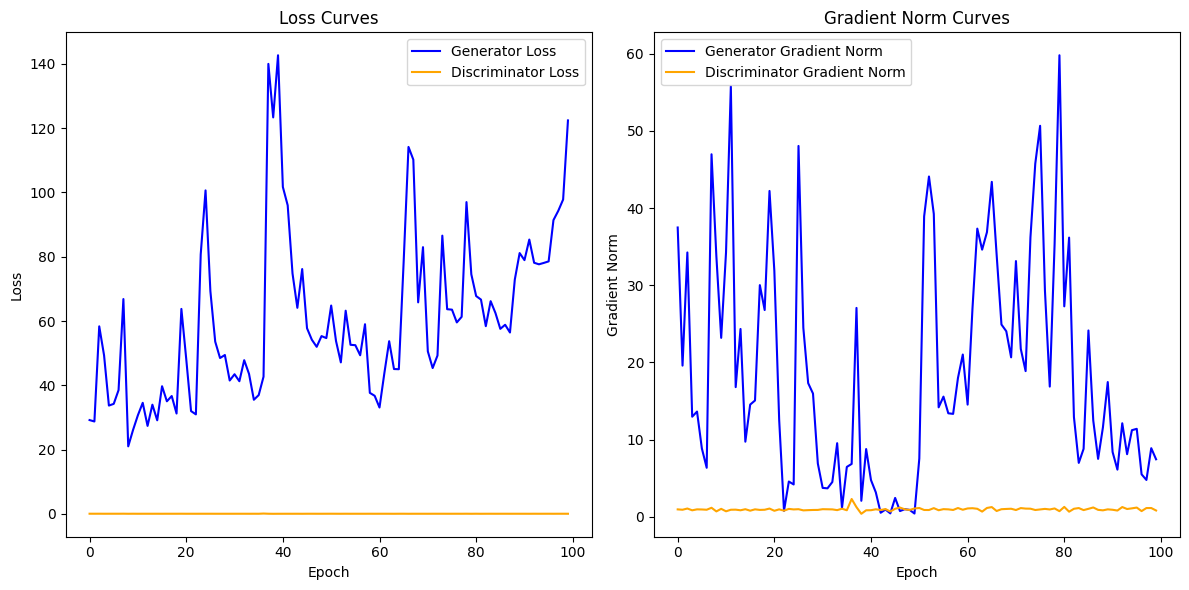

In [ ]:
# Ensure all values in the lists are CPU floats for plotting
D_l1 = [float(d.cpu()) if torch.is_tensor(d) else d for d in D_l1]
G_l1 = [float(g.cpu()) if torch.is_tensor(g) else g for g in G_l1]
D_grad_norms = [float(dg.cpu()) if torch.is_tensor(dg) else dg for dg in D_grad_norms]
G_grad_norms = [float(gg.cpu()) if torch.is_tensor(gg) else gg for gg in G_grad_norms]

# Plotting Loss Curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(G_l1, label="Generator Loss", color="blue")
plt.plot(D_l1, label="Discriminator Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Plotting Gradient Norm Curves
plt.subplot(1, 2, 2)
plt.plot(G_grad_norms, label="Generator Gradient Norm", color="blue")
plt.plot(D_grad_norms, label="Discriminator Gradient Norm", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Curves")
plt.legend()

plt.tight_layout()
plt.show()


### Image generation

In [29]:
from torchvision.utils import save_image

In [30]:
import torchvision

# Parameters
batch_size = 64  # Set your desired batch size
n_samples_target = 10000  # Total number of samples to generate

print('Model Loading...')
# Model Pipeline
mnist_dim = 784
model = Generator(g_output_dim=mnist_dim)
model = load_model(model, 'checkpoints',100)
model = torch.nn.DataParallel(model)
model.eval()

print('Model loaded.')
print('Start Generating')
os.makedirs('samples_new', exist_ok=True)

n_samples = 0
with torch.no_grad():
    while n_samples < n_samples_target:
        z = torch.randn(batch_size, 200)
        x = model(z)
        x = x.reshape(batch_size, 1, 28, 28)  # Reshape for saving
        for k in range(x.shape[0]):
            if n_samples < n_samples_target:
                torchvision.utils.save_image(x[k], os.path.join('samples_new', f'{n_samples}.png'))
                n_samples += 1

print('Generated samples done.')


Model Loading...
Model loaded.
Start Generating


<ipython-input-27-42bec91f78ff>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder, f'epoch_{epoch}_G.pth')))


Generated samples done.


### Calculating FID


In [31]:
from torchvision.utils import save_image
path_real = 'samples_real'
os.makedirs(path_real, exist_ok=True)

# Save a subset of real images to the directory
n_samples = 10000  # Set the number of real samples you want to save
for i in range(n_samples):
    image, _ = train_dataset[i]  # Get the i-th image
    save_image(image, os.path.join(path_real, f'real_sample_{i}.png'), normalize=True)

print(f"Saved {n_samples} real MNIST images to '{path_real}'.")



Saved 10000 real MNIST images to 'samples_real'.


In [33]:
import os
import shutil

# Clear the cache directory for torch models
cache_dir = os.path.expanduser("~/.cache/torch/hub/checkpoints")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)  # Deletes the model cache directory

print("Model cache cleared. Re-run the FID calculation to download a fresh model.")


Model cache cleared. Re-run the FID calculation to download a fresh model.


In [34]:
from pytorch_fid import fid_score

# Calculate FID between two directories

path_fake = "samples_new"
fid_value = fid_score.calculate_fid_given_paths([path_real, path_fake], batch_size=64, device='cuda', dims=2048)

print(f"FID Score: {fid_value}")


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 63.0MB/s]
100%|██████████| 157/157 [00:38<00:00,  4.12it/s]


FID Score: 251.5922871327348


In [ ]:
import os

# Check contents of the paths
print("Files in path_real:", os.listdir(path_real))
print("Files in path_fake:", os.listdir(path_fake))


Files in path_real: ['real_sample_1693.png', 'real_sample_9082.png', 'real_sample_2365.png', 'real_sample_6742.png', 'real_sample_4022.png', 'real_sample_1530.png', 'real_sample_8709.png', 'real_sample_3866.png', 'real_sample_5147.png', 'real_sample_2886.png', 'real_sample_7611.png', 'real_sample_3865.png', 'real_sample_6067.png', 'real_sample_8820.png', 'real_sample_1768.png', 'real_sample_7809.png', 'real_sample_847.png', 'real_sample_2536.png', 'real_sample_893.png', 'real_sample_7645.png', 'real_sample_2869.png', 'real_sample_1192.png', 'real_sample_3967.png', 'real_sample_9592.png', 'real_sample_8764.png', 'real_sample_7460.png', 'real_sample_348.png', 'real_sample_3403.png', 'real_sample_6215.png', 'real_sample_5749.png', 'real_sample_7252.png', 'real_sample_5850.png', 'real_sample_3295.png', 'real_sample_7299.png', 'real_sample_6922.png', 'real_sample_7881.png', 'real_sample_1228.png', 'real_sample_2023.png', 'real_sample_2150.png', 'real_sample_1220.png', 'real_sample_1502.png'

In [ ]:
from google.colab import files
!zip -r samples_new.zip samples_new/
files.download('samples_new.zip')


Streaming output truncated to the last 5000 lines.
  adding: samples_new/2670.png (deflated 1%)
  adding: samples_new/3201.png (deflated 1%)
  adding: samples_new/7491.png (stored 0%)
  adding: samples_new/1793.png (deflated 1%)
  adding: samples_new/683.png (stored 0%)
  adding: samples_new/4196.png (deflated 1%)
  adding: samples_new/1136.png (stored 0%)
  adding: samples_new/406.png (stored 0%)
  adding: samples_new/4549.png (deflated 1%)
  adding: samples_new/9294.png (stored 0%)
  adding: samples_new/8097.png (stored 0%)
  adding: samples_new/4509.png (deflated 1%)
  adding: samples_new/9437.png (deflated 1%)
  adding: samples_new/2981.png (stored 0%)
  adding: samples_new/7688.png (stored 0%)
  adding: samples_new/291.png (deflated 1%)
  adding: samples_new/6024.png (stored 0%)
  adding: samples_new/5840.png (stored 0%)
  adding: samples_new/6073.png (deflated 1%)
  adding: samples_new/8479.png (deflated 1%)
  adding: samples_new/6301.png (stored 0%)
  adding: samples_new/4511.pn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>